This particular implemenation of the best response functions of host-parasite coevolution assumes a negative quadratic functional form for the birth rate of infectives and that the transmissibility follows a power law. These choices  greatly simplifies the optimisation whiles also capturing the generic qualitative behaviour of other functional forms.

As discussed in the paper, we are concerned with the fixed point of the best response funtions,

>$\alpha^{**} = \alpha_{br}(\gamma^{**})$

>$\gamma^{**} = \gamma_{br}(\alpha^{**})$

However, instead of solving directly via an iterative scheme we'll make use of some helpful properties of our functions to obtain a more robust root finding problem, which has the added benefit of giving us the unstable fixed point too. Since $\gamma_{br}$ is easily inverted we can rearrange the second equation for $\alpha^{**}$ by applying the inverse
> $\gamma_{br}^{-1}(\gamma^{**}) = (\gamma_{br}^{-1}\circ\gamma_{br})(\alpha^{**}) =\alpha^{**}$

We can use the first equation to eliminate $\alpha^{**}$ and rearrange to see that the fixed points of the best response function are also roots of the map $\alpha_{br} - \gamma_{br}^{-1}$. Since we are only concerned with the roots of this function it suffices to consider its numerator, which is a cubic equation in $\gamma^{**}$. You can see this for yourself by clicking the 'show me roots' button in [this](https://www.desmos.com/calculator/6uwffvrldg) plot.

We'll make use of the ``` numpy.roots() ``` routine to determine the roots which coincide with both the stable and unstable fixed points. And to do so all we need to do is calculate the coefficients of said cubic equation (which can be done by hand or in your favourte symbolic algebra package). In this script the coefficients of the cubic equation are stored in the variable ```p```, whose values depend on a number of biological parameters.





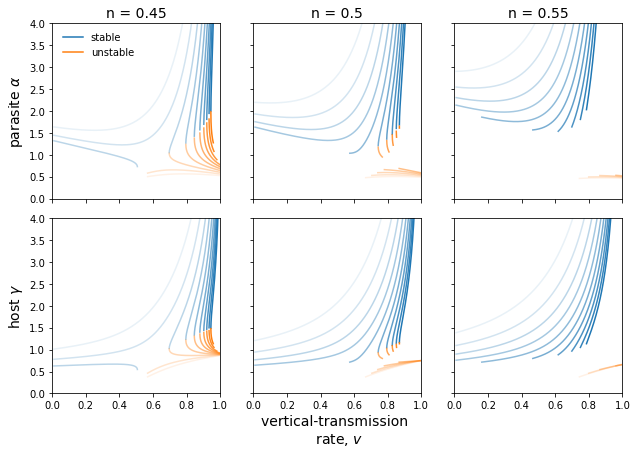

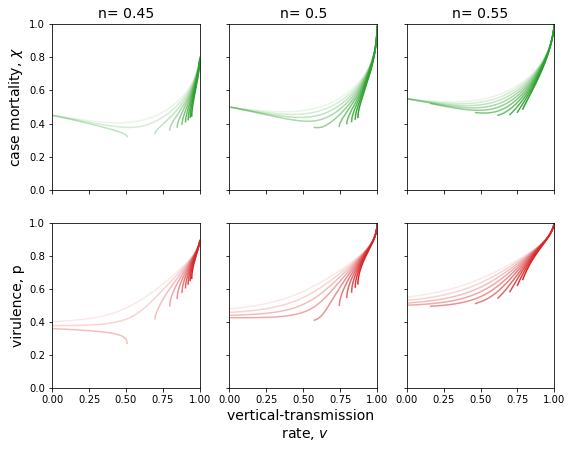

104.15978145599365


In [2]:
import matplotlib.pyplot as plt
from numpy import *
import csv

def bi(y,l,b):
  # Birth rate of infectives
  return b - l*y*y

def gbr(x,l,n,v,u,b):
  # Host's best response gamma
  return -(1-v)*(u+x) + ( ((1-v)*(u+x))**2 + (u+x-b)/l )**0.5

def abr(y,l,n,v,u,b):
  # Parasite's  best response alpha
  return n*(u + y - v*bi(y,l,b))/(1 - n)

def abr_boundary(n,v,u,b):
  return n*(u - v*b)/(1 - n)

# Equilibrium Ecology

def Sbar_num(x,y,l,v,u,b):
  # Numerator of the number of suseptible hosts at equilibrium
  return u + x + y - v*bi(y,l,b)

def Ibar_denom(x,y,l,u,b):
  # Denominator of the number of infective hosts at equilibrium 
  return u + x - bi(y,l,b)

# ------------------------------------------------------------------------------#

# Toggle if you would like to output a .csv file
save_to_file = False

# Biological Parameters (do not allow v=0,1 or n=0)
b       = 1.375                 # birth rate of infectives in the absence of immune response, b_0 
u       = 1                     # background mortality rate, mu
nvals   = linspace(.45, .55, 3) # transmissibility exponent, n
lambdas = linspace(.2,.6,10)    # cost to the host to clear the infection, lambda
vvals   = arange(0.01,1,0.0001) # vertical transmission probability, v

if save_to_file:
  f = open('outfile.csv', 'w')
  writer = csv.writer(f)
  writer.writerow([
                   'b0','mu','n','lambda','v',
                   'alpha stable','gamma stable','bi','sbar num','ibar denom',
                   'case mortality','virulence',
                   'alpha unstable','gamma unstable','bi','sbar num','ibar denom',
                   'alpha boundary','gamma boundary','bi','sbar num','ibar denom'
                  ])

# Initialise arrays to assign later
asvals = empty((len(lambdas), len(nvals), len(vvals))) # alpha stable
gsvals = empty((len(lambdas), len(nvals), len(vvals))) # gamma stable
auvals = empty((len(lambdas), len(nvals), len(vvals))) # alpha unstable
guvals = empty((len(lambdas), len(nvals), len(vvals))) # gamma unstable
abvals = empty((len(lambdas), len(nvals), len(vvals))) # alpha boundary
cmvals = empty((len(lambdas), len(nvals), len(vvals))) # case mortality 
vivals = empty((len(lambdas), len(nvals), len(vvals))) # virulence

# Loop through parameters
for k in range(len(lambdas)):
  l = lambdas[k]
  for i in range(len(nvals)):
    n = nvals[i]
    for j in range(len(vvals)):
      v = vvals[j]

      # Coefficients of the cubic whose roots coincide 
      # with the gamma coordinate of the fixed points.
      p = [2*l*l*(v-1)*v*n/(1-n),
           (l*v-2*l*(1-v))*n/(1-n)-l,
           (1-2*l*(1-v)*(u-b*v))*n/(1-n)-2*l*(1-v)*u,
           (u-b*v)*n/(1-n)+u-b]

      _ , unstable, stable = sort_complex(roots(p))
      
      # Once we have the fixed points we check to make 
      # sure they are biologically viable.

      gsv = real(stable)
      guv = real(unstable)

      if imag(stable) !=0:
        gsvals[k,i,j] = nan
        asvals[k,i,j] = nan
      else:      
        gsvals[k,i,j] = gsv
        asvals[k,i,j] = abr(gsv,l,n,v,u,b)

      if imag(unstable) != 0 or guv < 0:
        guvals[k,i,j] = nan
        auvals[k,i,j] = nan
        abvals[k,i,j] = nan
      else:
        guvals[k,i,j] = guv
        auvals[k,i,j] = abr(guv,l,n,v,u,b)
        abvals[k,i,j] = abr_boundary(n,v,u,b)
      
      flag_stable = any(array([ 
                                Sbar_num(asvals[k,i,j],gsvals[k,i,j],u,v,l,b),
                                Ibar_denom(asvals[k,i,j],gsvals[k,i,j],u,b,l),
                                bi(b,l,gsvals[k,i,j])                         
                              ]) <= 0)
      if flag_stable:
        gsvals[k,i,j] = nan
        asvals[k,i,j] = nan
      
      flag_unstable = any(array([ 
                                  Sbar_num(auvals[k,i,j],guvals[k,i,j],u,v,l,b),
                                  Ibar_denom(auvals[k,i,j],guvals[k,i,j],u,b,l),
                                  bi(b,l,guvals[k,i,j])                        
                                ]) <= 0)
      if flag_unstable:
        guvals[k,i,j] = nan
        auvals[k,i,j] = nan

      flag_boundary = any(array([ 
                                  Sbar_num(abvals[k,i,j],0,u,v,l,b),
                                  Ibar_denom(abvals[k,i,j],0,u,b,l),
                                  bi(b,l,0)    
                                ]) <= 0)
      
      if abr_boundary(n,v,u,b) <= 0 or flag_boundary:
        abvals[k,i,j] = nan

      # Calculate the case mortality and virulence
      cmvals[k,i,j] =  asvals[k,i,j]/(asvals[k,i,j]+ gsvals[k,i,j] + u)

      # difference version
      vivals[k,i,j] = (u + asvals[k,i,j] - bi(gsvals[k,i,j],l,b))/(asvals[k,i,j]+ gsvals[k,i,j] + u - v*bi(gsvals[k,i,j],l,b))
      # ratio version
      # vivals[k,i,j] = (u + asvals[k,i,j] + gsvals[k,i,j] - v*bi(gsvals[k,i,j],l,b))/(gsvals[k,i,j] + (1-v)*bi(gsvals[k,i,j],l,b))
          
      if save_to_file:
        writer.writerow([
        b,u,n,l,v,
        asvals[k,i,j],gsvals[k,i,j],bi(b,l,gsvals[k,i,j]),Sbar_num(asvals[k,i,j],gsvals[k,i,j],u,v,l,b),Ibar_denom(asvals[k,i,j],gsvals[k,i,j],u,b,l),
        cmvals[k,i,j],vivals[k,i,j],
        auvals[k,i,j],guvals[k,i,j],bi(b,l,guvals[k,i,j]),Sbar_num(auvals[k,i,j],guvals[k,i,j],u,v,l,b),Ibar_denom(auvals[k,i,j],guvals[k,i,j],u,b,l),
        abvals[k,i,j],0,bi(b,l,0),Sbar_num(abvals[k,i,j],0,u,v,l,b),Ibar_denom(abvals[k,i,j],0,u,b,l)])

if save_to_file:
  f.close()

# Plot and format the resulting data in two figures
# The first contains the parasite and host's best response equilibria

transparency = linspace(.1,1,len(lambdas))

fig, ax = plt.subplots(2,len(nvals), sharex='col', sharey='row',figsize = (3*len(nvals),6.7))

for k in range(len(lambdas)):
  for i in range(len(nvals)):
    ax[0,i].plot(vvals, asvals[k,i,:], c='tab:blue',alpha = transparency[k])
    ax[0,i].plot(vvals, auvals[k,i,:], c='tab:orange',alpha = transparency[k])
    ax[0,i].plot(vvals, abvals[k,i,:], c='tab:green')

    ax[1,i].plot(vvals, gsvals[k,i,:], c='tab:blue',alpha = transparency[k])
    ax[1,i].plot(vvals, guvals[k,i,:], c='tab:orange',alpha = transparency[k])
    
    ax[0,i].set_title(f'n = {nvals[i]}', fontsize=14)
    ax[0,i].set_xlim(0,1)

ax[0,0].set_ylabel(r'parasite $\alpha$', fontsize=14)
ax[0,0].set_ylim(0,4)    

ax[1,0].set_ylabel('host $\gamma$', fontsize=14)
ax[1,0].set_ylim(0,4)

ax[1,1].set_xlabel('vertical-transmission \n rate, $v$', fontsize=14)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
ax[0,0].legend(['stable','unstable'], bbox_to_anchor=(.01, 1), loc='upper left', frameon=False)
leg = ax[0,0].get_legend()
leg.legendHandles[0].set_alpha(1) 
leg.legendHandles[1].set_alpha(1) 

# The second shows the case mortality and virulence associated with the stable fixed point
fig2, ax2 = plt.subplots(2,len(nvals), sharex='col', sharey='row',figsize = (3*len(nvals),6.7))

for k in range(len(lambdas)):
    for i in range(len(nvals)):
      ax2[0,i].plot(vvals, cmvals[k,i,:], c='tab:green',alpha = transparency[k])
      ax2[0,i].set_title(f'n= {nvals[i]}', fontsize=14)
      ax2[0,i].set_xlim(0,1)     
      ax2[1,i].plot(vvals, vivals[k,i,:], c = 'tab:red', alpha = transparency[k])

ax2[0,0].set_ylabel(f'case mortality, $\chi$', fontsize=14)
ax2[0,0].set_ylim(0,1)

ax2[1,0].set_ylabel(f'virulence, p', fontsize=14)
ax2[1,0].set_ylim(0,1)

ax2[1,1].set_xlabel('vertical-transmission \n rate, $v$', fontsize=14)
fig2.tight_layout
plt.show()